# 4. Human myocardial infarction atlas
Kuppe, C., Ramirez Flores, R. O., Li, Z., Hayat, S., Levinson, R. T., Liao, X., ... & Kramann, R. (2022). Spatial multi-omic map of human myocardial infarction. Nature, 608(7924), 766-777.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro

#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

In [3]:
def convert_counts_to_df(counts, prop_cols=None, meta_cols=None, n_cells=1, column_name="Cluster"):
    """ Convert a cell count matrix to a dataframe in long format."""

    counts = counts.copy()

    #If not given, try to get prop_cols and meta_cols automatically
    if prop_cols is None:
        dtypes = counts.dtypes.astype(str)
        prop_cols = [col for i, col in enumerate(counts.columns) if "float" in dtypes[i] or "int" in dtypes[i]]
        
    if meta_cols is None:
        meta_cols = [col for col in counts.columns if col not in prop_cols]

    # Multiply proportions with n_cells
    counts[prop_cols] *= n_cells
    counts[prop_cols] = counts[prop_cols].astype(int)
    
    # Melt into long format (similar to adata.obs)
    counts_melt = pd.melt(counts, id_vars=meta_cols, value_vars=prop_cols, 
                          var_name=column_name, value_name="count")

    # Duplicate rows based on number of cells
    counts_long = counts_melt.loc[counts_melt.index.repeat(counts_melt["count"])].reset_index(drop=True)
    counts_long.drop(columns="count", inplace=True)
    counts_long.index = ["cell_" + str(i) for i in range(1, len(counts_long) + 1)]
    
    return counts_long

------------------

## Read data

In [4]:
human_MI_counts = pd.read_csv("data/human_MI_counts.tsv", sep="\t")
human_MI = convert_counts_to_df(human_MI_counts, column_name="cell_type")

In [5]:
human_MI.head()

,sample,major_label,cell_type
cell_1,CK158,CTRL,Adipocyte
cell_2,CK158,CTRL,Adipocyte
cell_3,CK159,FZ,Adipocyte
cell_4,CK159,FZ,Adipocyte
cell_5,CK159,FZ,Adipocyte


--------

-------------

## Compare Ischaemic zone vs Control

### With replicates

In [6]:
res_snrna = scanpro.scanpro(human_MI, samples_col='sample',
                            clusters_col='cell_type', conds_col='major_label', 
                            conditions=['CTRL','IZ'])

res_snrna.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_CTRL,mean_props_IZ,prop_ratio,t_statistics,p_values,adjusted_p_values
cell_type,,,,,,,
Adipocyte,0.000407,0.000355,0.002084,0.170583,0.019170,0.984957,0.984957
Cardiomyocyte,0.120837,0.442471,0.152491,2.901614,2.754764,0.014670,0.080683
Cycling cells,0.013488,0.005429,0.063373,0.085660,-5.800573,0.000034,0.000374
Endothelial,0.065925,0.146923,0.207000,0.709772,-1.280809,0.219574,0.301915
Fibroblast,0.103209,0.225862,0.271549,0.831755,-0.658671,0.520020,0.572022
Lymphoid,0.009500,0.012775,0.043002,0.297090,-2.238372,0.040671,0.095190
Mast,0.001449,0.003495,0.003041,1.149458,1.301492,0.212588,0.301915
Myeloid,0.050434,0.074778,0.185137,0.403904,-2.476843,0.025553,0.093696
Neuronal,0.004009,0.013734,0.007297,1.882211,2.206098,0.043268,0.095190


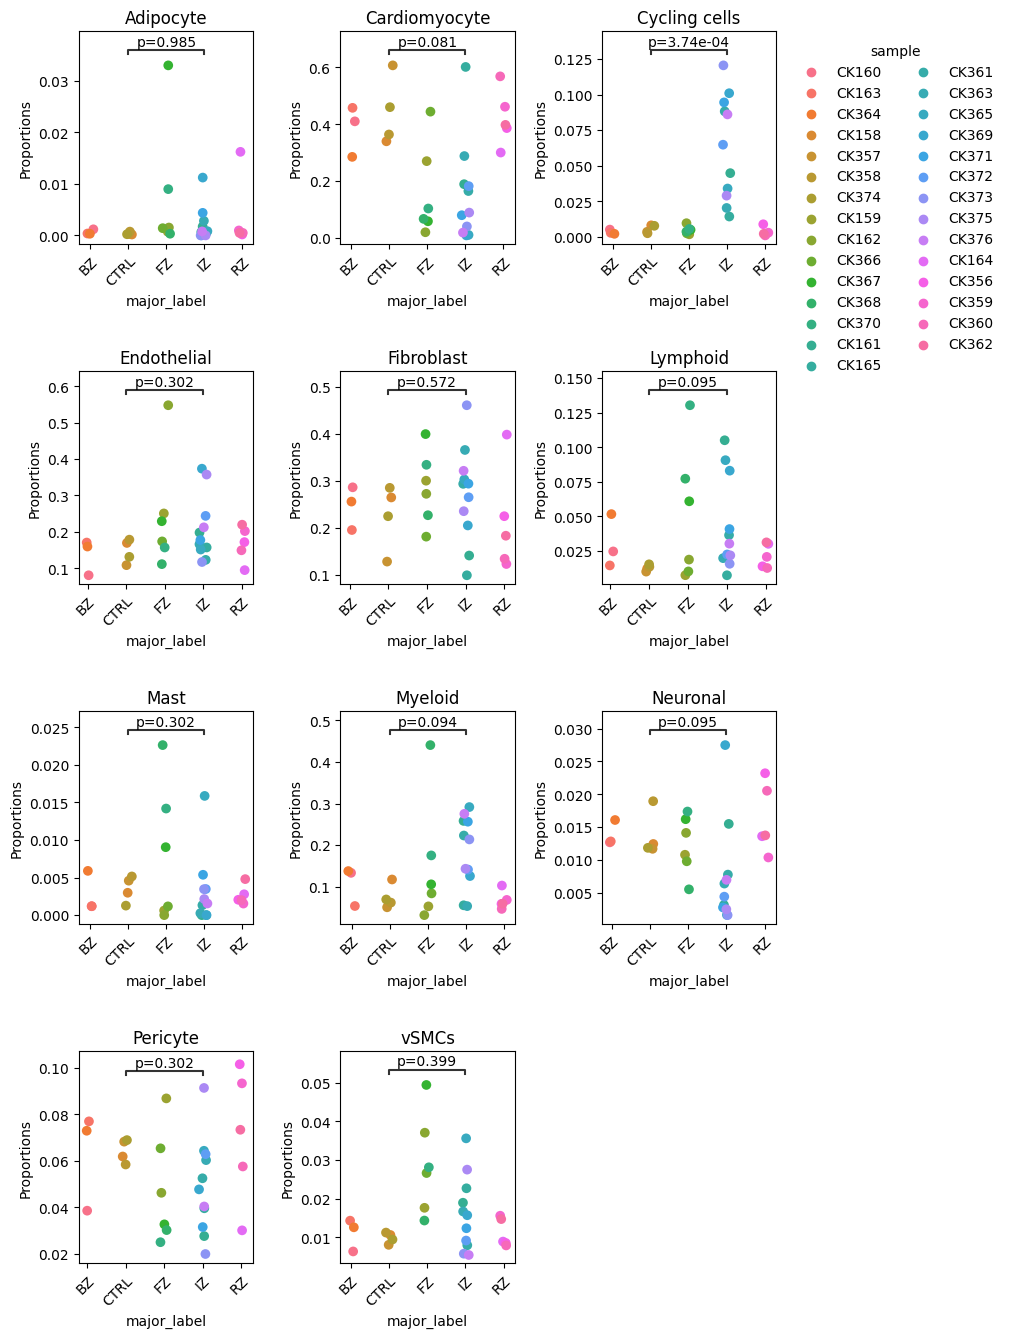

In [7]:
res_snrna.plot()

In [8]:
res_snrna.results.to_csv("results/humanMI_scanpro_rep.tsv", sep="\t")

### Without replicates

In [9]:
res_snrna_boot = scanpro.scanpro(human_MI, clusters_col='cell_type',
                                 conds_col='major_label', n_reps=8, conditions=['CTRL','IZ'],
                                 transform='arcsin')

res_snrna_boot.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 30.19 seconds


,baseline_props,mean_props_CTRL,mean_props_IZ,p_values
cell_type,,,,
Adipocyte,0.000407,0.000223,0.001419,0.178563
Cardiomyocyte,0.120837,0.436276,0.141448,0.000008
Cycling cells,0.013488,0.004124,0.066879,0.000029
Endothelial,0.065925,0.146893,0.185530,0.168422
Fibroblast,0.103209,0.223960,0.301999,0.045820
Lymphoid,0.009500,0.011469,0.036609,0.013908
Mast,0.001449,0.003106,0.002966,0.588567
Myeloid,0.050434,0.074171,0.186105,0.000530
Neuronal,0.004009,0.013424,0.004636,0.068889


In [10]:
res_snrna_boot.results.to_csv("results/humanMI_scanpro_norep.tsv", sep="\t")

-------------------

# Run propeller

In [11]:
human_MI_sub = human_MI[human_MI["major_label"].isin(["CTRL", "IZ"])]

In [12]:
%%R -i human_MI_sub -o propeller_results
library(speckle)

propeller_results = propeller(clusters = human_MI_sub$cell_type, sample = human_MI_sub$sample, 
                              group = human_MI_sub$major_label)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
Performing logit transformation of proportions
group variable has 2 levels, t-tests will be performed


In [13]:
propeller_results = propeller_results.sort_index()

In [14]:
propeller_results.to_csv("results/humanMI_propeller_rep.tsv", sep="\t")

-------------

## Compare results with/without replicates

In [15]:
# get results with and without replicates
compare = {'scanpro': -np.log10(res_snrna.results.iloc[:,-1]),
           'scanpro_noRep': -np.log10(res_snrna_boot.results.iloc[:,-1])}

compare = pd.DataFrame(compare, index=res_snrna.results.index)

compare

,scanpro,scanpro_noRep
cell_type,,
Adipocyte,0.006583,0.748209
Cardiomyocyte,1.093218,5.083692
Cycling cells,3.427232,4.534407
Endothelial,0.520116,0.773602
Fibroblast,0.242587,1.338940
Lymphoid,1.021411,1.856743
Mast,0.520116,0.230204
Myeloid,1.028280,3.275932
Neuronal,1.021411,1.161848


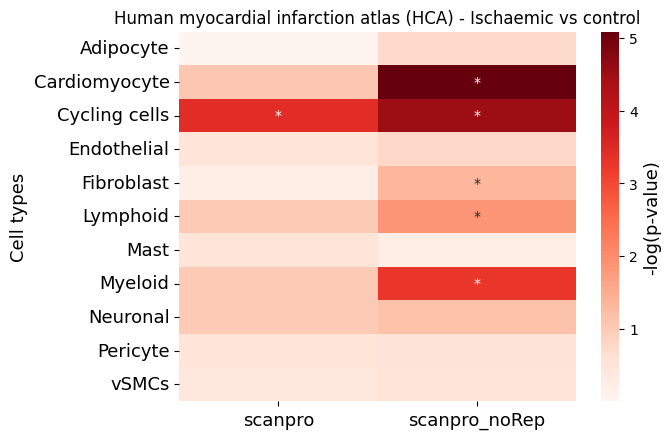

In [16]:
# annotation for heatmap
annot = {'scanpro': ['*' if value < 0.05 else '' for value in res_snrna.results.iloc[:,-1].to_list()],
         'scanpro_noRep': ['*' if value < 0.05 else '' for value in res_snrna_boot.results.iloc[:,-1].to_list()]}

ax = sns.heatmap(compare, annot=pd.DataFrame(annot), fmt='', 
                 cmap='Reds', 
                 cbar_kws={'label': '-log(p-value)'})
ax.set_ylabel('Cell types', fontsize=13)
ax.set_title("Human myocardial infarction atlas (HCA) - Ischaemic vs control")

plt.tick_params(axis='both', which='major', labelsize=13)
ax.figure.axes[-1].yaxis.label.set_size(13)

#plt.savefig(f'{FIG_PATH}/ischaemic_vs_ctrl.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'{FIG_PATH}/ischaemic_vs_ctrl.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
res_snrna_boot.props

cell_type,Adipocyte,Cardiomyocyte,Cycling cells,Endothelial,Fibroblast,Lymphoid,Mast,Myeloid,Neuronal,Pericyte,vSMCs
major_label,,,,,,,,,,,
BZ,0.000642,0.399924,0.003398,0.136391,0.241827,0.026840,0.002303,0.101510,0.013552,0.062514,0.011099
CTRL,0.000360,0.439479,0.005352,0.148213,0.226868,0.012649,0.003600,0.075727,0.013825,0.064062,0.009865
FZ,0.006434,0.211660,0.003621,0.217927,0.275472,0.040555,0.007019,0.144560,0.011336,0.055094,0.026322
IZ,0.001827,0.141133,0.068565,0.187627,0.299988,0.037560,0.003713,0.189048,0.005598,0.049713,0.015227
RZ,0.003699,0.434475,0.003248,0.161522,0.210619,0.020183,0.002403,0.066276,0.016916,0.070125,0.010533


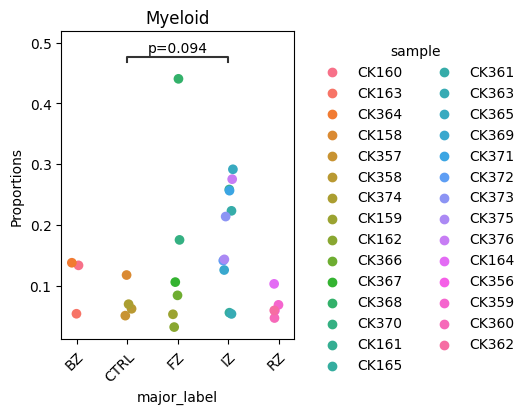

In [17]:
res_snrna.plot(clusters=["Myeloid"])

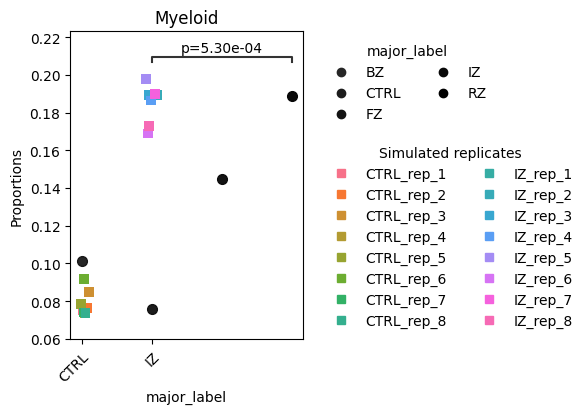

In [18]:
res_snrna_boot.plot(clusters=["Myeloid"])